Code for calculating population and coherence of a two-level coupled morse system
Adapted from A. Akimov, Modified by A. Green
6/24/21


Import modules and functions

In [1]:
import os
import sys
import math


if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
from libra_py import data_outs, data_read, data_visualize, dynamics_plotting
from libra_py.data_visualize import colors, clrs_index
from libra_py.models import Holstein, Martens
import libra_py.dynamics.exact.plot as exact_plot 
import util.libutil as comn

import matplotlib.pyplot as plt   # plots
import imageio

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=24)      # fontsize of the x and y labels
plt.rc('legend', fontsize=24)     # legend fontsize
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)


/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

Set up System

In [2]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn
import libra_py.units as units


class tmp:
    pass
def HolsteinM(q, params, full_id):
    """
    n-state model

    H_nn = E_n + de_n*(exp(-2*a_n*(x-x_n))-2*exp(-a_n*(x-x_n))

    H_n,n+1 = H_n+1,n = V,
    H_n,m = 0, otherwise

    """

    critical_params = ["E_n", "x_n", "de_n", "a_n" ]
    default_params = { "V":0.001 }
    comn.check_input(params, default_params, critical_params)

    E_n = params["E_n"]
    x_n = params["x_n"]
    de_n = params["de_n"]
    a_n = params["a_n"]
    V = params["V"]

    n = len(E_n)

    Hdia = CMATRIX(n,n)
    Sdia = CMATRIX(n,n)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(n,n) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(n,n) )

    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)

    Sdia.identity()

    for i in range(n):
        
        Hdia.set(i,i, (E_n[i]+ de_n[i] + de_n[i]*(math.exp(-2*a_n[i]*(x - x_n[i]))-2*math.exp(-a_n[i]*(x - x_n[i]))))*(1.0+0.0j))

    for i in range(n-1):
        Hdia.set(i,i+1,  V * (1.0+0.0j) )
        Hdia.set(i+1,i,  V * (1.0+0.0j) )

    for k in [0]:
        #  d Hdia / dR_0
        for i in range(n):
            d1ham_dia[k].set(i,i,  (-2*a_n[i]*de_n[i]*math.exp(a_n[i]*(x_n[i]-x))*(math.exp(a_n[i]*(x_n[i]-x))-1))*(1.0+0.0j) )

    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.dc1_dia = dc1_dia

    return obj

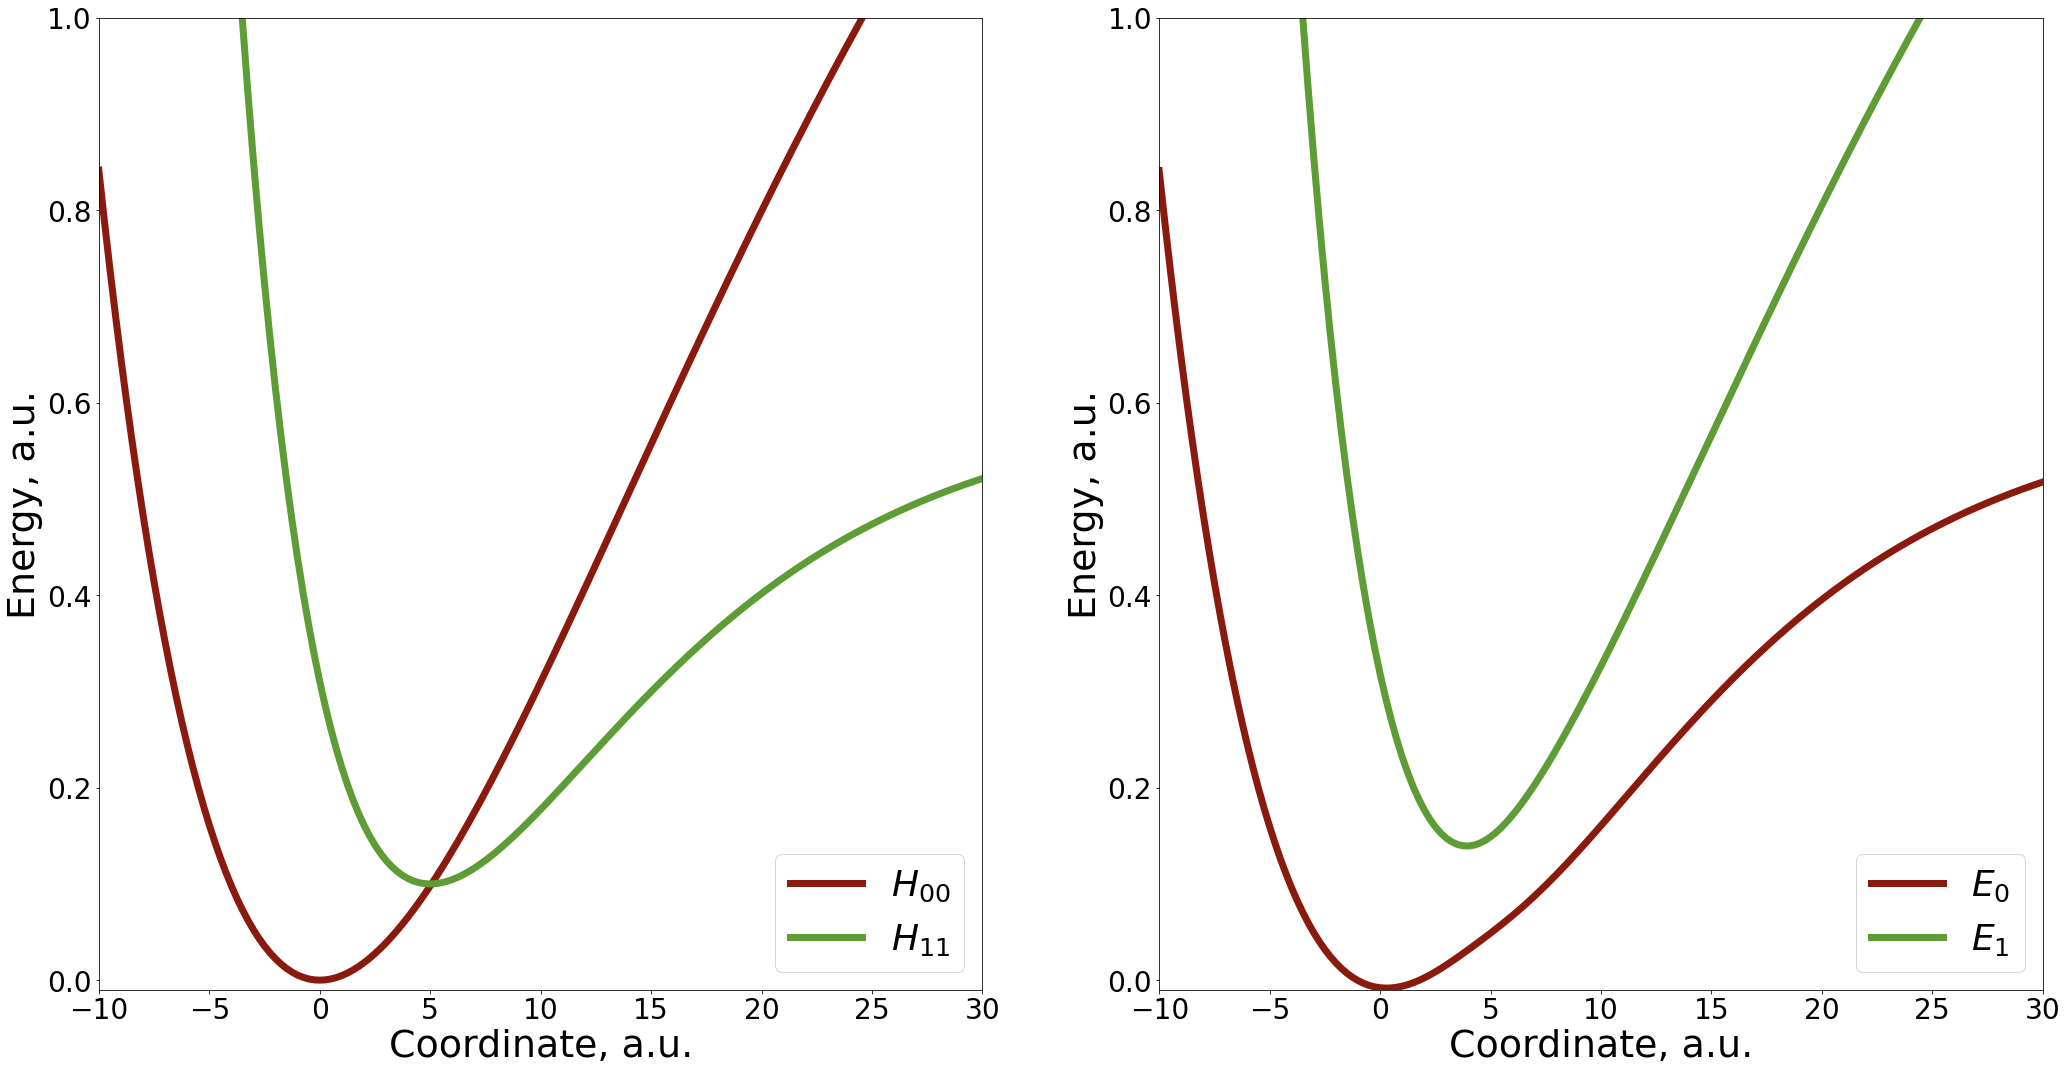

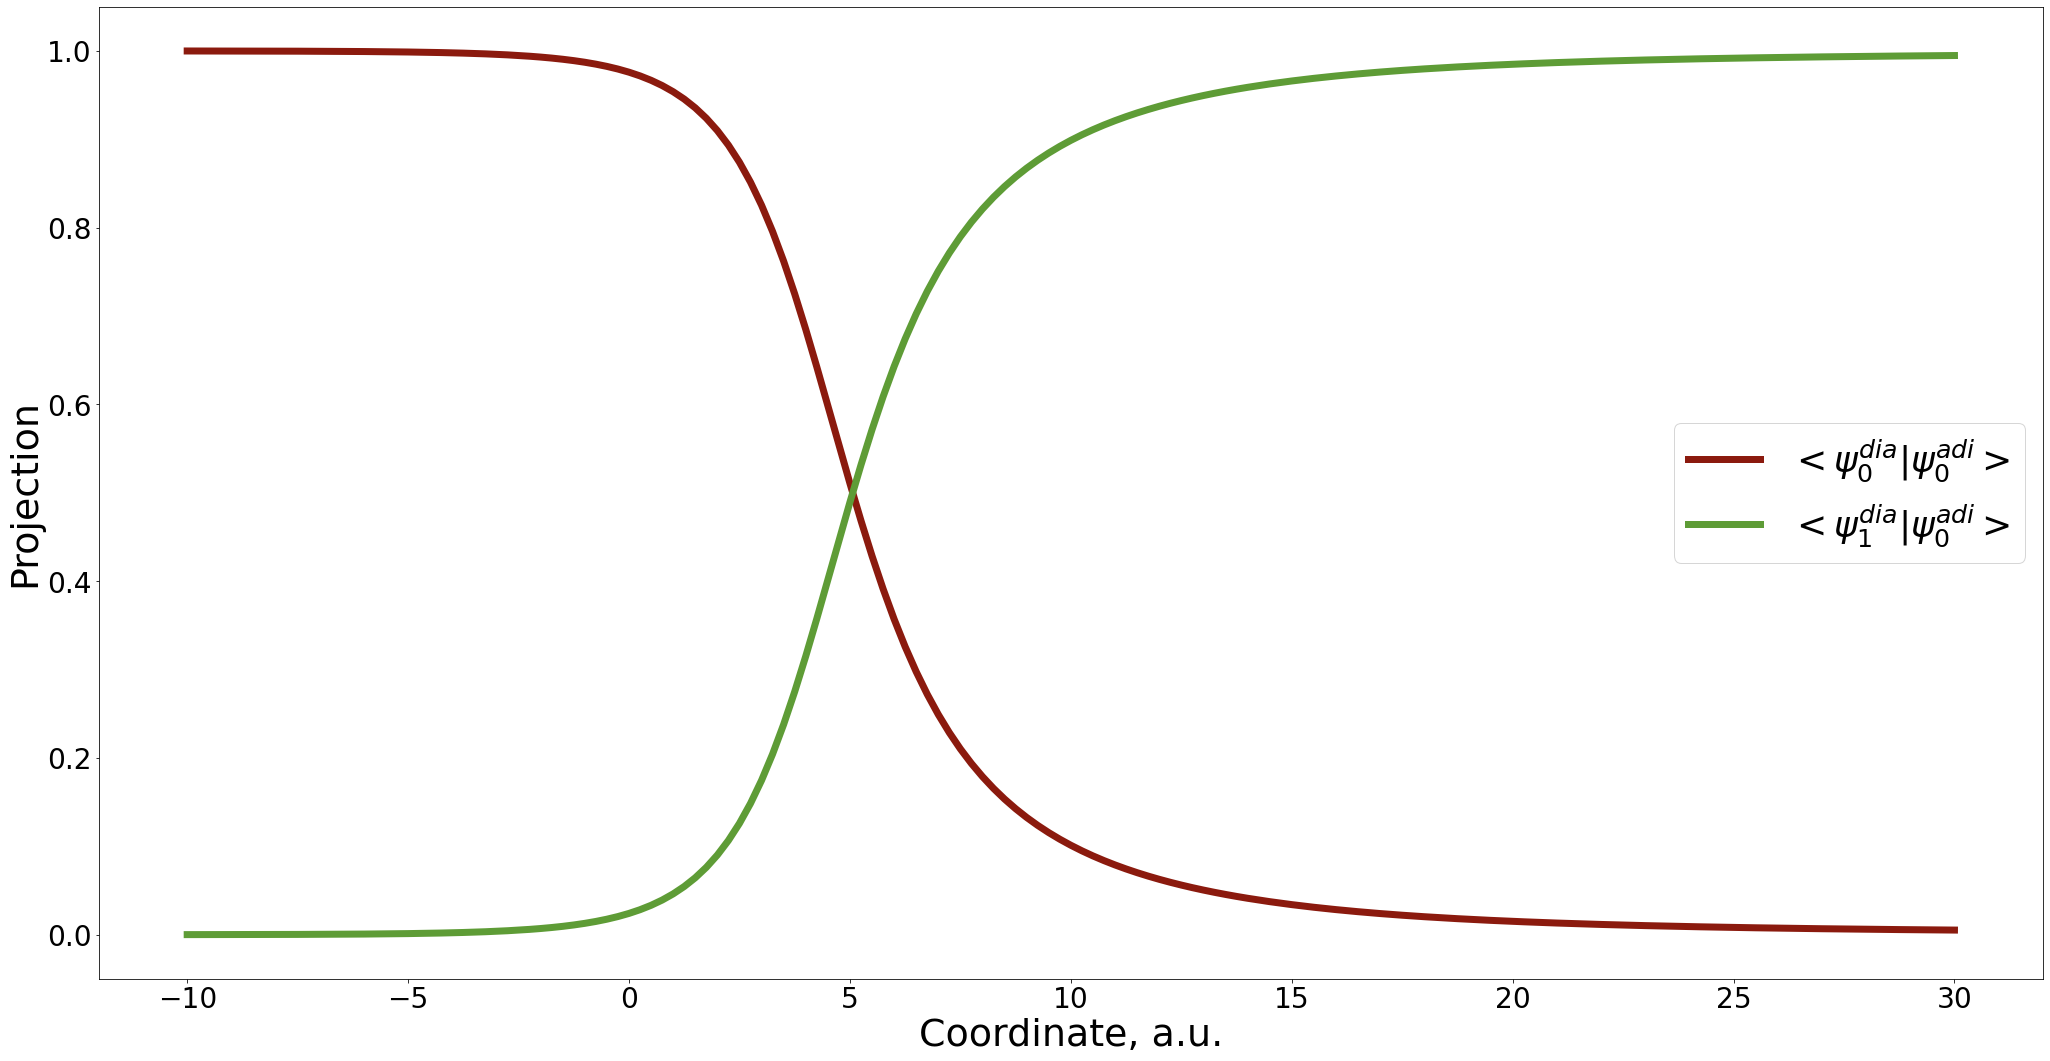

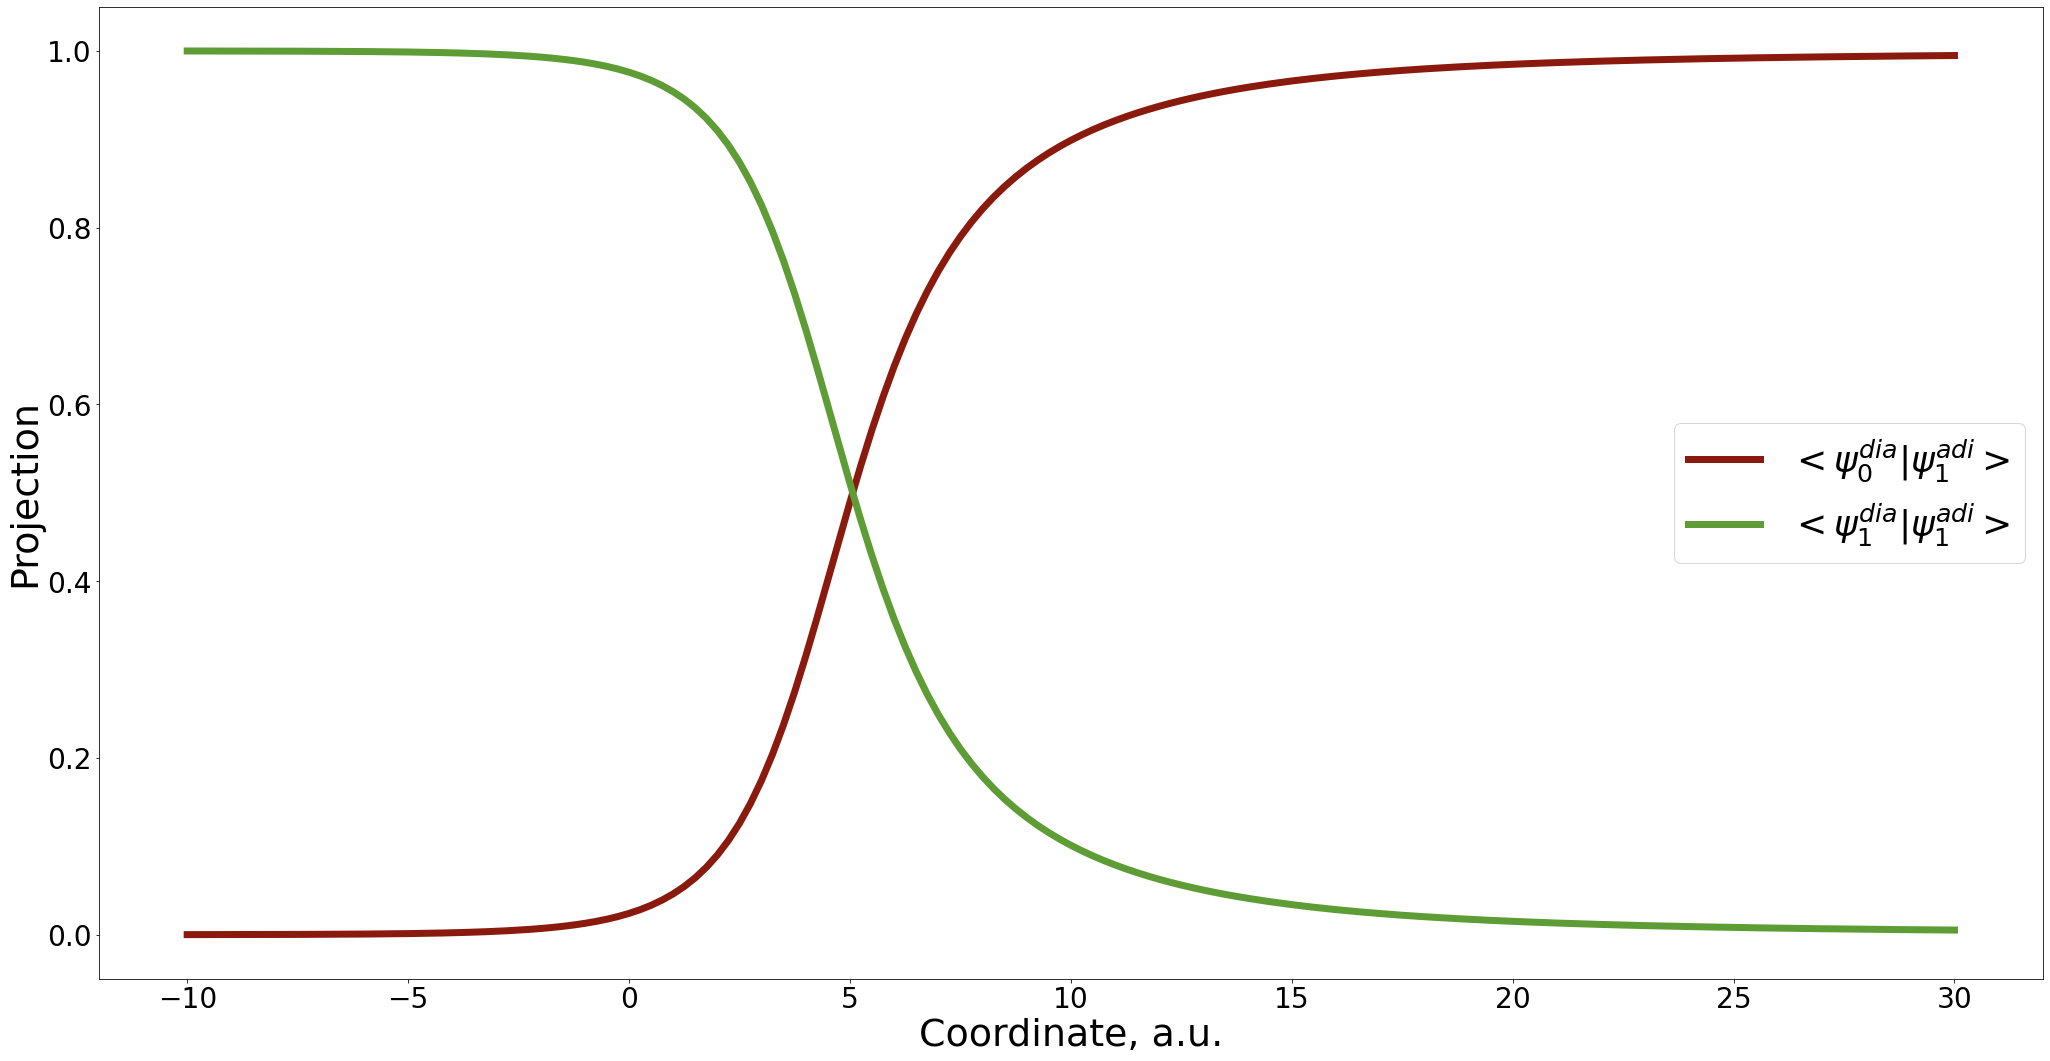

In [3]:
def compute_model(q, params):

    full_id = Py2Cpp_int([0,0])   
    
    mdl = params["model"]
    
    res = None
    if mdl == "HolsteinM":
        res = HolsteinM(q, params, full_id)
    elif mdl == "Martens1":
        res = Martens.model1(q, params, full_id)
    elif mdl == "Martens2":
        res = Martens.model2(q, params, full_id)

    return res

# Get Ham in diabatic rep for all points 
model_params = {"model": "HolsteinM",
                "E_n": [0.0, 0.1], "x_n":[0.0, 5.0], "de_n":[2.0, 0.5],"a_n":[0.05, 0.1], "V":0.05}
model_params.update(  { "nstates":2, "model":"HolsteinM"}  )

plot_params = {"colors": colors, "clrs_index": clrs_index, "ylim":[-0.01, 1.000], "xlim":[-10.0, 30.0]}
dynamics_plotting.plot_surfaces(HolsteinM, [ model_params ], [0,1], -10.0, 30.0, 0.25, plot_params)

Run dynamics and write out correlation functions

In [5]:
x0 = Py2Cpp_double([0.0]) # -3.0 -> 0.0
p0 = Py2Cpp_double([1.0])
alphas = Py2Cpp_double([0.1])
nu = Py2Cpp_int([0])
num_el_st = 2
el_st = 0 # 0 -> 1 ?
masses = Py2Cpp_double([20.0])

  
# Initialize the grid and do the mappings:
dx = 0.25
dt = 0.5
wfc = Wfcgrid2(Py2Cpp_double([-30.0]), Py2Cpp_double([30.0]),  Py2Cpp_double([dx]), num_el_st)



# Add a wavefunction in adiabatic basis 
wfc.add_wfc_HO(x0, p0, alphas, el_st, nu, 1.0+0.0j, 1)

wfc.update_Hamiltonian(compute_model, model_params, 0)
wfc.update_Hamiltonian(compute_model, model_params, 1)

# Compute the dia-to-adi transform matrix
wfc.update_propagator_H(0.5*dt)

# Compute the diabatic wfc
wfc.update_diabatic() 

# Compute the reciprocals
wfc.update_reciprocal(0)  # in diabatic  rep
wfc.update_reciprocal(1)  # in adiabatic rep


# Need the reciprocal space propagator
wfc.update_propagator_K(dt, masses)

# Now, we are ready to do the dynamics
nsteps = 50000

os.system("mkdir holstein-morse")
f = open("holstein-morse/dyn.txt", "w")

for step in range(nsteps):
    wfc.SOFT_propagate()
    wfc.update_reciprocal(0)  # in diabatic rep

    # Diabatic is the rep used for propagation, so we need to 
    # convert wfcs into adiabatic one
    wfc.update_adiabatic()
    wfc.update_reciprocal(1)  # in adiabatic rep

    Ddia = wfc.get_den_mat(0)  # diabatic density matrix
    Dadi = wfc.get_den_mat(1)  # adiabatic density matrix
    
    p0_dia = Ddia.get(0,0).real
    p0_adi = Dadi.get(0,0).real
    
    p1_dia = Ddia.get(1,1).real
    p1_adi = Dadi.get(1,1).real
    
    coh01_dia = Ddia.get(0,1).real
    coh01_adi = Dadi.get(0,1).real
    
    coh10_dia = Ddia.get(1,0).real
    coh10_adi = Dadi.get(1,0).real

    # Use the adiabatic wavefunction to compute the properties!
    q = wfc.get_pow_q(1, 1).get(0).real
    p = wfc.get_pow_p(1, 1).get(0).real
    
    f.write( F"{step} \t {p0_dia} \t {p1_dia} \t {coh01_dia}\n" )
 
f.close()
